In [75]:
# IMPORT
from IPython.display import Image, Math

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import pandas as pd
import pyAgrum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as pyc
import pyAgrum.causal.notebook as cslnb
import re
import pickle

In [76]:
def format_evidence_for_latex(evidence):
    formatted_evidence = []
    
    for var in evidence.keys():
        # Replace the part after the underscore with curly braces, if applicable
        var = re.sub(r'_(\w+)', r'_{\1}', var)  # Add {} around the part after the underscore
        
        # Replace '0' with '_{t-1}'
        var = var.replace('t', '_t')
        var = var.replace('0', '_{t-1}')

        # Append formatted variable to the list
        formatted_evidence.append(f"${var}$")  # Adding $ for LaTeX format
        
    return ', '.join(formatted_evidence)

def plot_distributions(var, distributions, var_midpoints):
    # Number of distributions to plot
    n = len(distributions)
    
    # Create subplots (one for each distribution)
    fig, axes = plt.subplots(1, n, figsize=(12, 4))

    # If there's only one plot, axes is not a list, so we handle it separately
    if n == 1:
        axes = [axes]
    var_midpoints = [round(float(m),2) for m in var_midpoints]
    for i, (data, title) in enumerate(distributions):
        # Plot the distribution in the corresponding subplot
        axes[i].bar(range(len(data)), data)
        axes[i].set_xticks(range(len(data)), var_midpoints, rotation='vertical')
        var_str = format_evidence_for_latex({var: None})
        axes[i].set_xlabel(f"{var_str} States")
        axes[i].set_ylabel("Probability")
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()
    
def find_bin(value, edges):
    """
    Given a continuous value and an array of bin edges,
    return the index of the bin that contains the value.
    """
    idx = np.digitize(value, edges, right=False) - 1
    return int(max(0, min(idx, len(edges) - 2)))


def get_info(D, auditDict, var):
    quantiles = np.linspace(0, 100, auditDict[var]['param'] + 1 if 'param' in auditDict[var] else auditDict[var]['nbBins'] + 1)
    edges = np.percentile(D[var].values, quantiles)
    midpoints = [(edges[i] + edges[i+1]) / 2.0 for i in range(len(edges)-1)]
    return quantiles, edges, midpoints

In [77]:
# DATA
DAGDIR = '/home/lcastri/git/causalflow/results/BL100_21102024/res.pkl'
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
BAGNAME= ['noncausal-11022025']

for bagname in BAGNAME:
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        for tod in TOD:
            if tod is TOD.H10: continue
            if tod is TOD.OFF: continue
            files = [f for f in os.listdir(os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}"))]
            files_split = [f.split('_') for f in files]
            wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
            wp_file = '_'.join(wp_files)
            print(f"Loading : {wp_file}")
            filename = os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{tod.value}", wp_file)

            df = pd.read_csv(filename)
            dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break
    
# concat_df = concat_df[concat_df['R_V']>0.01]
# concat_df = concat_df[concat_df['R_V']<=0.75]

    
D = concat_df.drop('pf_elapsed_time', axis=1)
D = D.drop('T', axis=1)
D = D.drop('R_X', axis=1)
D = D.drop('R_Y', axis=1)
D = D.drop('G_X', axis=1)
D = D.drop('G_Y', axis=1)
D = D.drop('NP', axis=1)
D = D.drop('R_B', axis=1)
D = D.drop('ELT', axis=1)
D = D.drop('C_S', axis=1)
D = D.drop('TOD', axis=1)
D = D.drop('WP', axis=1)
D = D.drop('PD', axis=1)
original_names = list(D.columns)
D.columns = [f'{v}t' for v in original_names]

# Add lagged variable
for v in original_names:
    D[f'{v}0'] = np.concatenate([D[f'{v}t'].values[1:], [0]])
D = D.iloc[1:].reset_index(drop=True)  # Remove first row
D = D.iloc[:-1].reset_index(drop=True)  # Remove last row

Loading : noncausal-11022025_H1_door-entrance.csv
Loading : noncausal-11022025_H2_door-entrance.csv
Loading : noncausal-11022025_H3_door-entrance.csv
Loading : noncausal-11022025_H4_door-entrance.csv
Loading : noncausal-11022025_H5_door-entrance.csv
Loading : noncausal-11022025_H6_door-entrance.csv
Loading : noncausal-11022025_H7_door-entrance.csv
Loading : noncausal-11022025_H8_door-entrance.csv
Loading : noncausal-11022025_H9_door-entrance.csv


In [78]:
# DATA
DAGDIR = '/home/lcastri/git/causalflow/results/BL100_21102024/res.pkl'
INDIR = '/home/lcastri/git/PeopleFlow/utilities_ws/src/RA-L/hrisim_postprocess/csv'
BAGNAME= ['noncausal-11022025']

for bagname in BAGNAME:
    for wp in WP:
        dfs = []
        if wp == WP.PARKING or wp == WP.CHARGING_STATION: continue
        files = [f for f in os.listdir(os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{TOD.H10.value}"))]
        files_split = [f.split('_') for f in files]
        wp_files = [f for f in files_split if len(f) == 3 and f[2].split('.')[0] == wp.value][0]
        wp_file = '_'.join(wp_files)
        print(f"Loading : {wp_file}")
        filename = os.path.join(INDIR, "HH/my_nonoise", f"{bagname}", f"{TOD.H10.value}", wp_file)
        df = pd.read_csv(filename)
        dfs.append(df)
        concat_df = pd.concat(dfs, ignore_index=True)
        break
    
    
Dtest = concat_df.drop('pf_elapsed_time', axis=1)
Dtest = Dtest.drop('T', axis=1)
Dtest = Dtest.drop('R_X', axis=1)
Dtest = Dtest.drop('R_Y', axis=1)
Dtest = Dtest.drop('G_X', axis=1)
Dtest = Dtest.drop('G_Y', axis=1)
Dtest = Dtest.drop('NP', axis=1)
Dtest = Dtest.drop('R_B', axis=1)
Dtest = Dtest.drop('ELT', axis=1)
Dtest = Dtest.drop('C_S', axis=1)
Dtest = Dtest.drop('TOD', axis=1)
Dtest = Dtest.drop('WP', axis=1)
Dtest = Dtest.drop('PD', axis=1)
original_names = list(Dtest.columns)
Dtest.columns = [f'{v}t' for v in original_names]

# Add lagged variable
for v in original_names:
    Dtest[f'{v}0'] = np.concatenate([Dtest[f'{v}t'].values[1:], [0]])
Dtest = Dtest.iloc[1:].reset_index(drop=True)  # Remove first row
Dtest = Dtest.iloc[:-1].reset_index(drop=True)  # Remove last row

Loading : noncausal-11022025_H10_door-entrance.csv



** audit **
- R_Vt : 
    + method : quantile
    + nbBins : 10
    + type : Continuous
    + minInData : 4.512177156357211e-05
    + maxInData : 0.8833266467462408
- Lt : 
    + method : NoDiscretization
    + values : [0. 1.]
    + type : Discrete
- ECt : 
    + method : quantile
    + nbBins : 10
    + type : Continuous
    + minInData : 0.0
    + maxInData : 0.1898634135212849
- R_V0 : 
    + method : quantile
    + nbBins : 10
    + type : Continuous
    + minInData : 4.512177156357211e-05
    + maxInData : 0.8833266467462408
- L0 : 
    + method : NoDiscretization
    + values : [0. 1.]
    + type : Discrete
- EC0 : 
    + method : quantile
    + nbBins : 10
    + type : Continuous
    + minInData : 0.0
    + maxInData : 0.1898634135212849


/tmp/ipykernel_58644/3130701901.py:3: DeprecationWarning: 
** pyAgrum.skbn.BNDiscretizer is deprecated since pyAgrum>1.15.0. A pyAgrum.lib.Discretizer has been created.

  discretizer=skbn.BNDiscretizer(defaultDiscretizationMethod='quantile')
/tmp/ipykernel_58644/3130701901.py:9: DeprecationWarning: 
  ** Discretizer.discretizedBN is deprecated since pyAgrum>1.15.0. Please use Discretizer.discretizeTemplate instead.
  
  template = discretizer.discretizedBN(D)


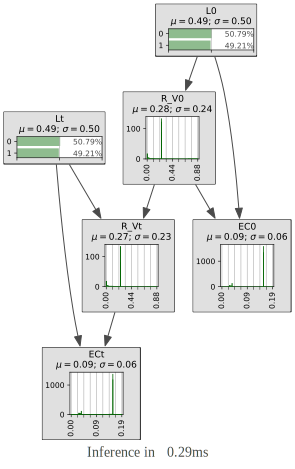

In [79]:
# DISCRETIZATION -- BN CREATION 

discretizer=skbn.BNDiscretizer(defaultDiscretizationMethod='quantile')
# discretizer.setDiscretizationParameters('R_V0','quantile', 4)
# discretizer.setDiscretizationParameters('R_Vt','quantile', 4)
# discretizer.setDiscretizationParameters('EC0','quantile', 4)
# discretizer.setDiscretizationParameters('ECt','quantile', 4)

template = discretizer.discretizedBN(D)
auditDict=discretizer.audit(D)
print()
print("** audit **")
for var in auditDict:
    print(f"- {var} : ")
    for k,v in auditDict[var].items():
        print(f"    + {k} : {v}")
        

template.addArc("L0", "EC0")
template.addArc("L0", "R_V0")
template.addArc("R_V0", "EC0")
template.addArc("Lt", "R_Vt")
template.addArc("Lt", "ECt")
template.addArc("R_Vt", "ECt")
template.addArc("R_V0", "R_Vt")
learner = pyAgrum.BNLearner(D, template)
learner.useSmoothingPrior()
bn = learner.learnParameters(template)

time_slices_bn = gdyn.getTimeSlices(bn, size=20)

gnb.showInference(bn)

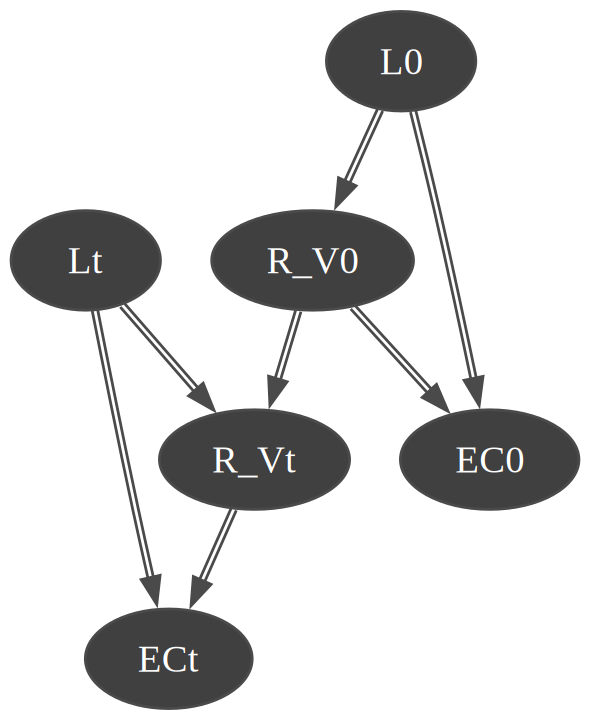

<IPython.core.display.Math object>

In [80]:
cm = pyc.CausalModel(bn)

# ------------------------------
# Evaluate Predictions on a Test Set using BN inference and CausalModel (do-intervention)
# ------------------------------
cslnb.showCausalModel(cm, size="10!")
a = pyc.doCalculusWithObservation(cm,"EC0", {"R_V0"})
display(Math(a.toLatex()))



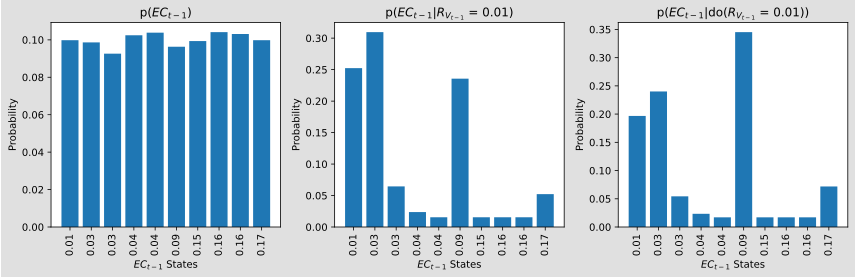

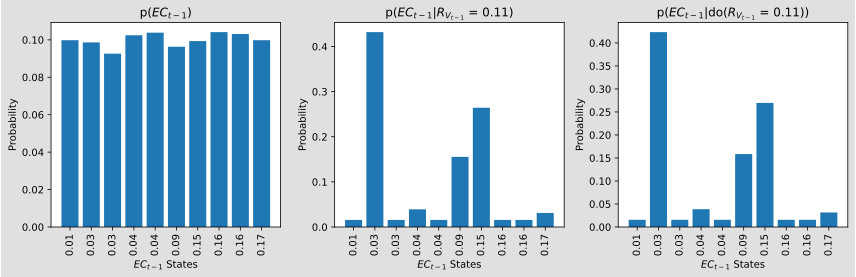

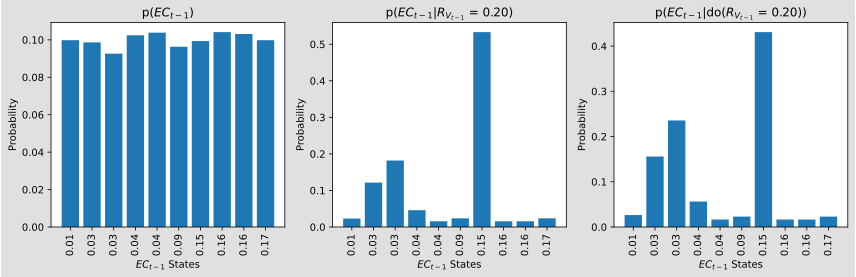

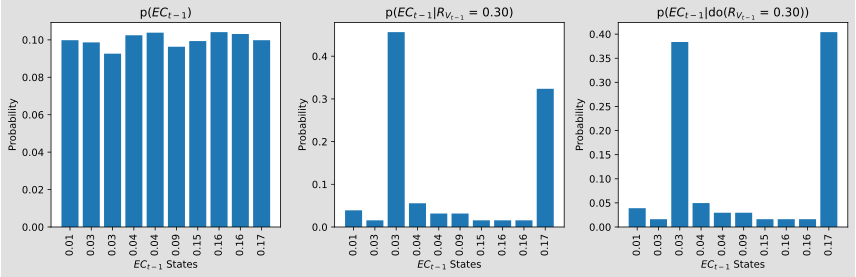

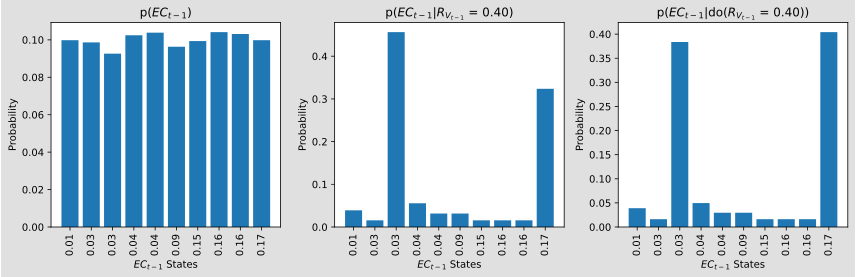

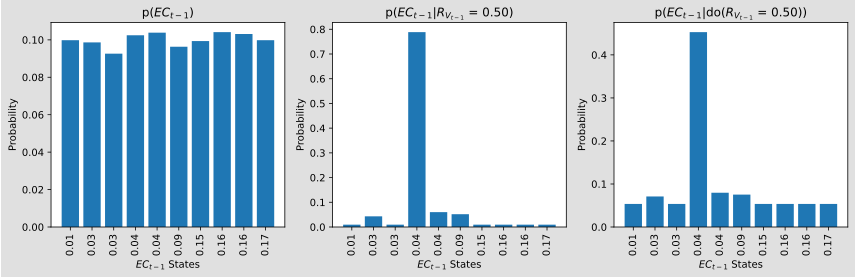

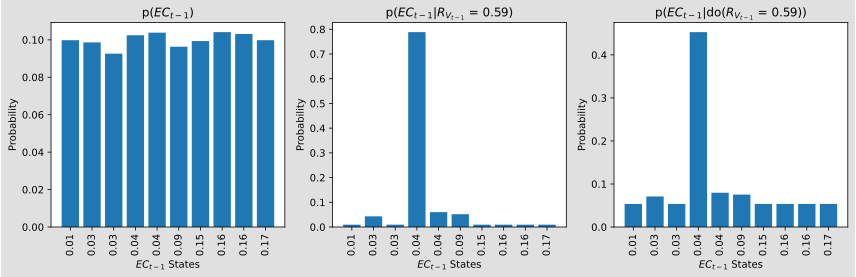

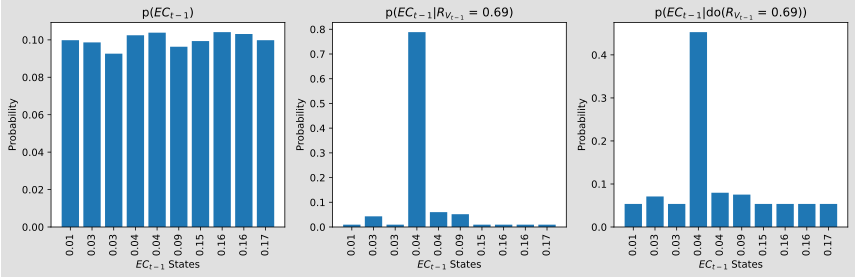

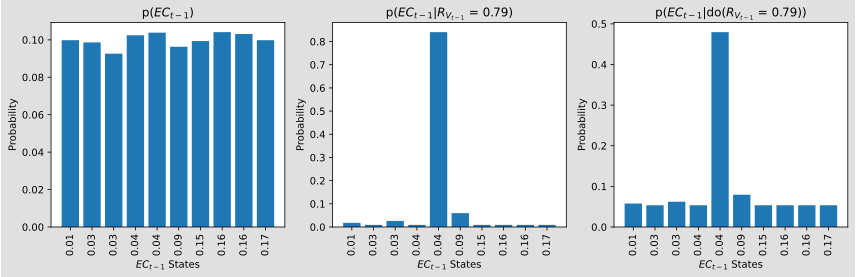

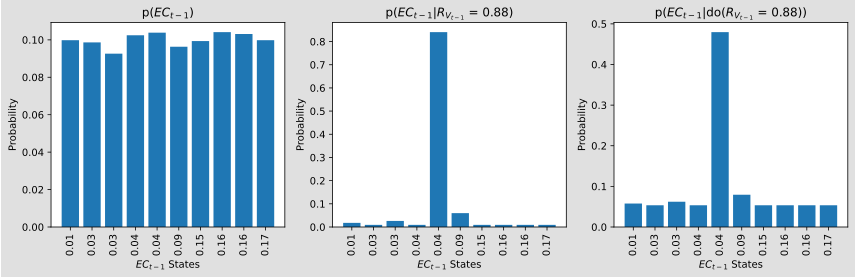

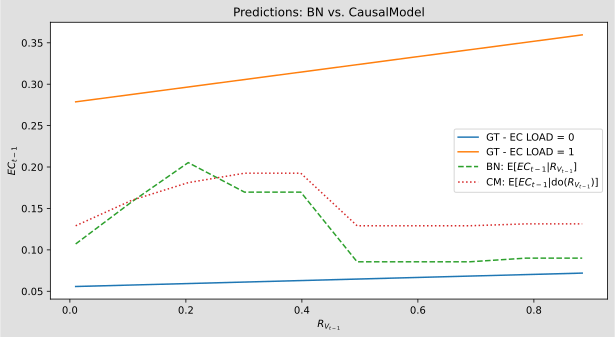

In [81]:
import math
import networkx as nx

def heuristic(a, b):
    pos = nx.get_node_attributes(G, 'pos')
    (x1, y1) = pos[a]
    (x2, y2) = pos[b]
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def get_distance(wp_origin, wp_dest):
    pos = nx.get_node_attributes(G, 'pos')
    path = nx.astar_path(G, wp_origin, wp_dest, heuristic=heuristic, weight='weight')
    dist = []
    for wp_idx in range(1, len(path)):
        (x1, y1) = pos[path[wp_idx-1]]
        (x2, y2) = pos[path[wp_idx]]
        dist.append(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))
    return dist

static_duration = 5
dynamic_duration = 4
charging_time = 2
LOAD_FACTOR = 5
NOLOAD_ROBOT_MAX_VEL = 0.75
LOAD_ROBOT_MAX_VEL = 0.25
K_nl_s = 100 / (static_duration * 3600)
K_nl_d = (100 / (dynamic_duration * 3600) - K_nl_s)/(NOLOAD_ROBOT_MAX_VEL)
K_l_s = K_nl_s * LOAD_FACTOR
K_l_d = K_nl_d * LOAD_FACTOR

quantiles_R_V0, edges_R_V0, midpoints_R_V0 = get_info(D, auditDict, 'R_V0')
quantiles_EC0, edges_EC0, midpoints_EC0 = get_info(D, auditDict, 'EC0')
STEP = 5

RV_range = np.linspace(0.01, max(D['R_V0']), 10)
gt_noload = []
gt_load = []
bayes_prediction = []
causal_prediction = []
time = 10
for RV_val in RV_range:
    GTLOAD = time * (K_l_s + K_l_d * RV_val) 
    GTNOLOAD = time * (K_nl_s + K_nl_d * RV_val)

    RV_bin_idx = find_bin(RV_val, edges_R_V0)
    target_var = 'EC0'
    target_var_str = format_evidence_for_latex({target_var: None})
    
    # --- BN prediction ---
    ie = pyAgrum.VariableElimination(bn)
    bn_prior = ie.posterior(target_var)
    evidence = {"R_V0": RV_bin_idx}
    # evidence = {"R_V0": RV_bin_idx, "L0": 1}
    evidence_str = format_evidence_for_latex(evidence)
    ie.setEvidence(evidence)
    ie.makeInference()
    bn_posterior = ie.posterior(target_var)
    bn_posterior_values = bn_posterior.toarray()
    pred_bn = sum(bn_posterior_values[j] * midpoints_EC0[j] for j in range(len(bn_posterior_values)))
    # pred_bn = midpoints_EC0[np.argmax(bn_posterior_values)] 
    bayes_pred = (time/STEP)*pred_bn
    
    # --- CausalModel prediction ---
    formula, adj, exp = pyc.causalImpact(cm, on="EC0", doing="R_V0", values=evidence)
    # formula, adj, exp = pyc.causalImpact(cm, on="EC0", doing="R_V0", knowing={"L0"}, values=evidence)
    formula.toLatex()
    posterior_causal = adj.toarray()
    pred_causal = sum(posterior_causal[j] * midpoints_EC0[j] for j in range(len(posterior_causal)))
    # pred_causal = midpoints_EC0[np.argmax(posterior_causal)]
    causal_pred = (time/STEP)*pred_causal
    
    plot_distributions(target_var, [(bn_prior.toarray(), f"p({target_var_str})"), 
                                    (bn_posterior_values, f"p({target_var_str}|" + f"{evidence_str} = {RV_val:.2f})"),
                                    (posterior_causal, f"p({target_var_str}|" + f"do({evidence_str} = {RV_val:.2f}))")],
                       midpoints_EC0)
    
    gt_noload.append(GTNOLOAD)
    gt_load.append(GTLOAD)
    bayes_prediction.append(bayes_pred)
    causal_prediction.append(causal_pred)
    
# ------------------------------
# Plot Predictions and Residuals
# ------------------------------
# Plot predicted vs. ground truth
plt.figure(figsize=(10, 5))
plt.plot(RV_range, gt_noload, label=f'GT - EC LOAD = 0')
plt.plot(RV_range, gt_load, label=f'GT - EC LOAD = 1')
plt.plot(RV_range, bayes_prediction, label=f'BN: E[{target_var_str}|{evidence_str}]', linestyle='--')
plt.plot(RV_range, causal_prediction, label=f"CM: E[{target_var_str}|do({evidence_str})]", linestyle=':')
plt.ylabel(f'{target_var_str}')
plt.xlabel(r'$R_{V_{t-1}}$')
plt.title('Predictions: BN vs. CausalModel')
plt.legend()
plt.show()

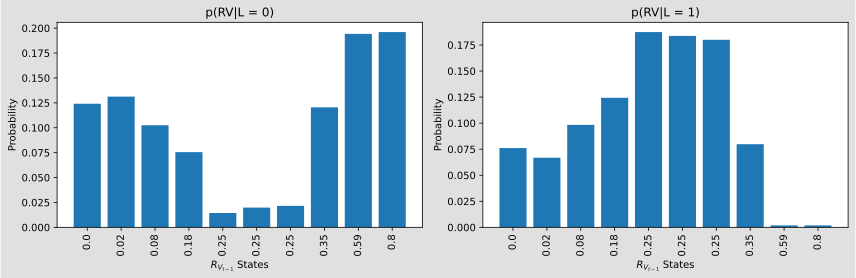

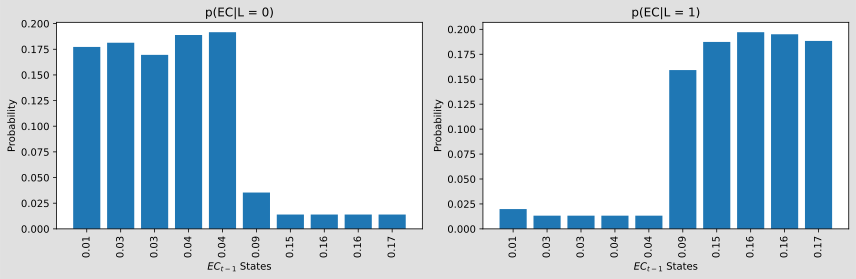

In [82]:
plot_distributions('R_V0', [(bn.cpt(bn.idFromName("R_V0"))[0], f"p(RV|L = 0)"), 
                            (bn.cpt(bn.idFromName("R_V0"))[1], f"p(RV|L = 1)")],
                   midpoints_R_V0)

ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior("EC0")
evidence = {"L0": 0}
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
ec_given_L0 = bn_posterior.toarray()

ie = pyAgrum.VariableElimination(bn)
bn_prior = ie.posterior("EC0")
evidence = {"L0": 1}
ie.setEvidence(evidence)
ie.makeInference()
bn_posterior = ie.posterior(target_var)
ec_given_L1 = bn_posterior.toarray()
plot_distributions('EC0', [(ec_given_L0, f"p(EC|L = 0)"), 
                            (ec_given_L1, f"p(EC|L = 1)")],
                   midpoints_EC0)